In [1]:
import csv as csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import os
import time
import statsmodels.api as smdl
import pprint as pp
import re

from math import pi
from numpy import histogram
from numpy import histogram
from bokeh.layouts import row, column
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.models import NumeralTickFormatter
from sklearn import metrics
from scipy import stats
from scipy.cluster.vq import kmeans,vq
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from functools import reduce

output_notebook()

Loading BokehJS ...

In [ ]:
#functions
def trimToIntersect(df, col_name, I):
    df = df[df[col_name].apply(lambda x: x in I)]
    return df

In [2]:
file2011='Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv'
file2012='Medicare_Provider_Charge_Inpatient_DRG100_FY2012.csv'
file2013='Medicare_Provider_Charge_Inpatient_DRG100_FY2013.csv'
file2014='Medicare_Provider_Charge_Inpatient_DRGALL_FY2014.csv'
file2015='Medicare_Provider_Charge_Inpatient_DRGALL_FY2015.csv'
file2016='Medicare_Provider_Charge_Inpatient_DRGALL_FY2016.csv'


df2011 = pd.read_csv(file2011)
df2012 = pd.read_csv(file2012)
df2013 = pd.read_csv(file2013)
df2014 = pd.read_csv(file2014)
df2015 = pd.read_csv(file2015)
df2016 = pd.read_csv(file2016)


#some empty rows in file
df2013 = df2013.dropna()
df2013.isnull().values.any()

#remove special chars
messy_cols = ['Total Discharges','Average Covered Charges', 'Average Total Payments', 'Average Medicare Payments']
df2016[messy_cols] = df2016[messy_cols].replace({'\$': '', ',': ''}, regex=True)
df2016[messy_cols] = df2016[messy_cols].astype(np.float64)


/home/mai/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
def getDRGCodes(df):
        codes = df['DRG Definition'].apply(lambda x: int(re.match('\d{3}', x).group(0)))
        return codes
    
df2011['DRG Code'] = getDRGCodes(df2011)
df2012['DRG Code'] = getDRGCodes(df2012)
df2013['DRG Code'] = getDRGCodes(df2013)
df2014['DRG Code'] = getDRGCodes(df2014)
df2015['DRG Code'] = getDRGCodes(df2015)
df2016['DRG Code'] = getDRGCodes(df2016)

codes2011 = df2011['DRG Code'].unique()
codes2012 = df2012['DRG Code'].unique()
codes2013 = df2013['DRG Code'].unique()
codes2014 = df2014['DRG Code'].unique()
codes2015 = df2015['DRG Code'].unique()
codes2016 = df2016['DRG Code'].unique()


#get intersection of values
I = reduce(np.intersect1d, (codes2011, codes2012, codes2013, codes2014, codes2015, codes2016))



array([ 39,  57,  64,  65,  66,  69,  74, 101, 176, 177, 178, 189, 190,
       191, 192, 193, 194, 195, 202, 207, 208, 243, 244, 246, 247, 251,
       252, 253, 254, 280, 281, 282, 286, 287, 291, 292, 293, 300, 303,
       305, 308, 309, 310, 312, 313, 314, 315, 329, 330, 372, 377, 378,
       379, 389, 390, 391, 392, 394, 418, 439, 460, 469, 470, 473, 480,
       481, 482, 536, 552, 563, 602, 603, 638, 640, 641, 682, 683, 684,
       689, 690, 698, 699, 811, 812, 853, 870, 871, 872, 885, 897, 917,
       918, 948])

In [5]:
## remove DRGs not with subset

df2011 = trimToIntersect(df2011, 'DRG Code', I)
df2012 = trimToIntersect(df2012, 'DRG Code', I)
df2013 = trimToIntersect(df2013, 'DRG Code', I)
df2014 = trimToIntersect(df2014, 'DRG Code', I)
df2015 = trimToIntersect(df2015, 'DRG Code', I)
df2016 = trimToIntersect(df2016, 'DRG Code', I)


In [106]:
len(df2016['Provider Id'].unique())

3189

In [6]:

def groupByDRG(df):
    #recover original values
    df['Total Charges'] = df['Total Discharges'] * df['Average Covered Charges']
    df['Total Payments'] = df['Total Discharges'] * df['Average Total Payments']
    df['Total Medicare Payments'] = df['Total Discharges'] * df['Average Medicare Payments']

    #group by DRG, take sums
    newdf = df.groupby(['DRG Definition'], as_index=False).agg({ 'Total Discharges':'sum',
                                              'Total Charges': 'sum',
                                              'Total Payments':'sum',
                                              'Total Medicare Payments': 'sum' })

    #calcuate new averages
    newdf['Average Charges'] = newdf['Total Charges']/newdf['Total Discharges']
    newdf['Average Payments'] = newdf['Total Payments']/newdf['Total Discharges']
    newdf['Average Medicare Payment'] = newdf['Total Medicare Payments']/newdf['Total Discharges']
    newdf['Average Non Medicare Payment'] = newdf['Average Payments'] - newdf['Average Medicare Payment']
    
    newdf['DRG Code'] = getDRGCodes(newdf)
    newdf.drop(columns=['Total Charges', 'Total Payments', 'Total Medicare Payments'], inplace=True)
    newdf = newdf.sort_values(by='Average Charges', ascending=False)
    
    return newdf


grpDRG2011 = groupByDRG(df2011)







In [7]:
grpDRG2012 = groupByDRG(df2012)

In [8]:
grpDRG2013 = groupByDRG(df2013)

In [9]:
grpDRG2014 = groupByDRG(df2014)

In [10]:
grpDRG2015 = groupByDRG(df2015)

In [11]:
grpDRG2016 = groupByDRG(df2016)

In [12]:
## add year to column

def addYearToCols(df, year):
    df = df.rename(columns={"Total Discharges": "Total Discharges-" + str(year),
                            "Average Charges": "Average Charges-" + str(year),
                            "Average Payments" : "Average Payments-" + str(year),
                            "Average Medicare Payment": "Average Medicare Payment-" + str(year),
                            "Average Non Medicare Payment": "Average Non Medicare Payment-" + str(year)})
    return df

grpDRG2011 = addYearToCols(grpDRG2011, 2011)
grpDRG2012 = addYearToCols(grpDRG2012, 2012)
grpDRG2013 = addYearToCols(grpDRG2013, 2013)
grpDRG2014 = addYearToCols(grpDRG2014, 2014)
grpDRG2015 = addYearToCols(grpDRG2015, 2015)
grpDRG2016 = addYearToCols(grpDRG2016, 2016)



In [13]:
dfs = [grpDRG2011, grpDRG2012, grpDRG2013, grpDRG2014, grpDRG2015, grpDRG2016 ]
df_merged = reduce(lambda  left,right: pd.merge(left,right, on='DRG Code'), dfs )
df_merged

DRG Definition_x  Total Discharges-2011  \
0    870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS                  22624   
1   207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...                  26412   
2   853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...                  39482   
3    329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC                  37250   
4   246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...                  27104   
5         460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC                  65997   
6               252 - OTHER VASCULAR PROCEDURES W MCC                  34222   
7   469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...                  18714   
8   480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...                  17851   
9                253 - OTHER VASCULAR PROCEDURES W CC                  36434   
10     243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC                  29646   
11    330 - MAJOR SMALL & LARGE BOWEL PROCEDURES W CC                  50766   
12  251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY...                  28583   
13  208 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...                  68080   
14  247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...                 108272   
15  286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...                  21820   
16  244 - PERMANENT CARDIAC PACEMAKER IMPLANT W/O ...                  27951   
17            473 - CERVICAL SPINAL FUSION W/O CC/MCC                  23834   
18  177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...                  66660   
19  064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...                  62093   
20  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...                 427207   
21     314 - OTHER CIRCULATORY SYSTEM DIAGNOSES W MCC                  51079   
22  871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...                 319072   
23  481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...                  77525   
24  418 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...                  18227   
25                        377 - G.I. HEMORRHAGE W MCC                  48398   
26         254 - OTHER VASCULAR PROCEDURES W/O CC/MCC                  26385   
27  280 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...                  63934   
28  698 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W...                  22085   
29                          682 - RENAL FAILURE W MCC                 101029   
..                                                ...                    ...   
63  066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...                  55849   
64                 202 - BRONCHITIS & ASTHMA W CC/MCC                  32086   
65  282 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...                  21596   
66                552 - MEDICAL BACK PROBLEMS W/O MCC                  63116   
67                             101 - SEIZURES W/O MCC                  48854   
68                                638 - DIABETES W CC                  48025   
69                           069 - TRANSIENT ISCHEMIA                  79590   
70  309 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDER...                 102484   
71             812 - RED BLOOD CELL DISORDERS W/O MCC                  92851   
72                           312 - SYNCOPE & COLLAPSE                 141918   
73  392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...                 244854   
74                           603 - CELLULITIS W/O MCC                 140894   
75    690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC                 206695   
76  563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...                  20278   
77                   379 - G.I. HEMORRHAGE W/O CC/MCC                  33393   
78                                    885 - PSYCHOSES                  89733   
79                     948 - SIGNS & SYMPTOMS W/O MCC                  50411   
80  192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/...                 114790   
81       195 - SIMPLE PNEUMONIA & PLE

In [14]:

dup_cols = df_merged['DRG Definition_x']
df_merged['DRG Definition'] = dup_cols.iloc[:,0]
df_merged.drop(columns=['DRG Definition_x', 'DRG Definition_y'], inplace=True)
df_merged

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
0                   22624         163325.924727           45800.304897   
1                   26412         143768.966115           39075.223118   
2                   39482         141995.086546           41267.558178   
3                   37250         135584.770120           38262.291436   
4                   27104          93363.315895           23336.481921   
5                   65997          92884.270225           27347.608649   
6                   34222          84391.353866           23389.605020   
7                   18714          79518.005077           22350.119429   
8                   17851          74927.733741           20972.504285   
9                   36434          68656.565159           17657.076549   
10                  29646          67968.686804           18181.944377   
11                  50766          65481.843615           18239.712879   
12                  28583          65054.383480           13877.647413   
13                  68080          62710.196842           16407.986017   
14                 108272          61985.034007           14292.068300   
15                  21820          61115.131897           15560.630614   
16                  27951          53134.335301           13990.301027   
17                  23834          52934.927834           14400.059872   
18                  66660          51383.269607           13857.547315   
19                  62093          50511.485981           13773.065869   
20                 427207          50105.260780           14324.484035   
21                  51079          49438.290902           13909.480608   
22                 319072          49418.600159           13650.959467   
23                  77525          48304.420884           12588.735556   
24                  18227          48091.444451           11518.103308   
25                  48398          46459.449729           12730.230898   
26                  26385          46399.256888           11668.784461   
27                  63934          46373.314262           12661.111944   
28                  22085          42212.746570           12369.462440   
29                 101029          40258.705372           11683.246751   
..                    ...                   ...                    ...   
63                  55849          23864.610468            5787.118068   
64                  32086          23776.084523            6082.141432   
65                  21596          23000.158455            5539.060937   
66                  63116          22808.392024            5841.400485   
67                  48854          22428.108261            5798.661031   
68                  48025          21892.232650            6069.980760   
69                  79590          21830.054705            5074.530142   
70                 102484          21461.879581            5849.762626   
71                  92851          20855.350648            5738.285210   
72                 141918          20541.310806            5156.213271   
73                 244854          20321.546816            5097.075817   
74                 140894          20272.376255            5887.524316   
75                 206695          19865.560768            5409.828549   
76                  20278          19464.267876            5171.738041   
77                  33393          18974.565897            5030.734196   
78                  89733          18761.074766            7180.196683   
79                  50411          18739.868620            4946.972347   
80                 114790          18120.848210            4936.957671   
81                  79873          18077.543851            4830.268188   
82                  22728          17837.788983            4821.377772   
83                 153660          17836.171899            4878.886301   
84                  25205          17734.803610            4485.602539   
85      

In [15]:
df_merged

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
0                   22624         163325.924727           45800.304897   
1                   26412         143768.966115           39075.223118   
2                   39482         141995.086546           41267.558178   
3                   37250         135584.770120           38262.291436   
4                   27104          93363.315895           23336.481921   
5                   65997          92884.270225           27347.608649   
6                   34222          84391.353866           23389.605020   
7                   18714          79518.005077           22350.119429   
8                   17851          74927.733741           20972.504285   
9                   36434          68656.565159           17657.076549   
10                  29646          67968.686804           18181.944377   
11                  50766          65481.843615           18239.712879   
12                  28583          65054.383480           13877.647413   
13                  68080          62710.196842           16407.986017   
14                 108272          61985.034007           14292.068300   
15                  21820          61115.131897           15560.630614   
16                  27951          53134.335301           13990.301027   
17                  23834          52934.927834           14400.059872   
18                  66660          51383.269607           13857.547315   
19                  62093          50511.485981           13773.065869   
20                 427207          50105.260780           14324.484035   
21                  51079          49438.290902           13909.480608   
22                 319072          49418.600159           13650.959467   
23                  77525          48304.420884           12588.735556   
24                  18227          48091.444451           11518.103308   
25                  48398          46459.449729           12730.230898   
26                  26385          46399.256888           11668.784461   
27                  63934          46373.314262           12661.111944   
28                  22085          42212.746570           12369.462440   
29                 101029          40258.705372           11683.246751   
..                    ...                   ...                    ...   
63                  55849          23864.610468            5787.118068   
64                  32086          23776.084523            6082.141432   
65                  21596          23000.158455            5539.060937   
66                  63116          22808.392024            5841.400485   
67                  48854          22428.108261            5798.661031   
68                  48025          21892.232650            6069.980760   
69                  79590          21830.054705            5074.530142   
70                 102484          21461.879581            5849.762626   
71                  92851          20855.350648            5738.285210   
72                 141918          20541.310806            5156.213271   
73                 244854          20321.546816            5097.075817   
74                 140894          20272.376255            5887.524316   
75                 206695          19865.560768            5409.828549   
76                  20278          19464.267876            5171.738041   
77                  33393          18974.565897            5030.734196   
78                  89733          18761.074766            7180.196683   
79                  50411          18739.868620            4946.972347   
80                 114790          18120.848210            4936.957671   
81                  79873          18077.543851            4830.268188   
82                  22728          17837.788983            4821.377772   
83                 153660          17836.171899            4878.886301   
84                  25205          17734.803610            4485.602539   
85      

In [16]:
long_df = pd.wide_to_long(df_merged, ['Total Discharges',
                                       'Average Charges',
                                       'Average Payments',
                                       'Average Medicare Payment',
                                       'Average Non Medicare Payment'], i='DRG Code', j='Year', sep='-')
long_df

DRG Definition  \
DRG Code Year                                                      
870      2011   870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS   
207      2011  207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...   
853      2011  853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...   
329      2011   329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC   
246      2011  246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...   
460      2011        460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC   
252      2011              252 - OTHER VASCULAR PROCEDURES W MCC   
469      2011  469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...   
480      2011  480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...   
253      2011               253 - OTHER VASCULAR PROCEDURES W CC   
243      2011     243 - PERMANENT CARDIAC PACEMAKER IMPLANT W CC   
330      2011    330 - MAJOR SMALL & LARGE BOWEL PROCEDURES W CC   
251      2011  251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY...   
208      2011  208 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...   
247      2011  247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...   
286      2011  286 - CIRCULATORY DISORDERS EXCEPT AMI, W CARD...   
244      2011  244 - PERMANENT CARDIAC PACEMAKER IMPLANT W/O ...   
473      2011            473 - CERVICAL SPINAL FUSION W/O CC/MCC   
177      2011  177 - RESPIRATORY INFECTIONS & INFLAMMATIONS W...   
64       2011  064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...   
470      2011  470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...   
314      2011     314 - OTHER CIRCULATORY SYSTEM DIAGNOSES W MCC   
871      2011  871 - SEPTICEMIA OR SEVERE SEPSIS W/O MV 96+ H...   
481      2011  481 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...   
418      2011  418 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...   
377      2011                        377 - G.I. HEMORRHAGE W MCC   
254      2011         254 - OTHER VASCULAR PROCEDURES W/O CC/MCC   
280      2011  280 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...   
698      2011  698 - OTHER KIDNEY & URINARY TRACT DIAGNOSES W...   
682      2011                          682 - RENAL FAILURE W MCC   
...                                                          ...   
66       2016  066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...   
202      2016                 202 - BRONCHITIS & ASTHMA W CC/MCC   
282      2016  282 - ACUTE MYOCARDIAL INFARCTION, DISCHARGED ...   
552      2016                552 - MEDICAL BACK PROBLEMS W/O MCC   
101      2016                             101 - SEIZURES W/O MCC   
638      2016                                638 - DIABETES W CC   
69       2016                           069 - TRANSIENT ISCHEMIA   
309      2016  309 - CARDIAC ARRHYTHMIA & CONDUCTION DISORDER...   
812      2016             812 - RED BLOOD CELL DISORDERS W/O MCC   
312      2016                           312 - SYNCOPE & COLLAPSE   
392      2016  392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...   
603      2016                           603 - CELLULITIS W/O MCC   
690      2016    690 - KIDNEY & URINARY TRACT INFECTIONS W/O MCC   
563      2016  563 - FX, SPRN, STRN & DISL EXCEPT FEMUR, HIP,...   
379      2016                   379 - G.I. HEMORRHAGE W/O CC/MCC   
885      2016                                    885 - PSYCHOSES   
948      2016                     948 - SIGNS & SYMPTOMS W/O MCC   
192      2016  192 - CHRONIC OBSTRUCTIVE PULMONARY DISEASE W/...   
195      2016       195 - SIMPLE PNEUMONIA & PLEURISY W/O CC/MCC   
536      2016            536 - FRACTURES OF HIP & PELVIS W/O MCC   
641      2016  641 - MISC DISORDERS OF NUTRITION,METABOLISM,F...   
305      2016                         305 - HYPERTENSION W/O MCC   
390      2016                  390 - G.I. OBSTRUCTION W/O CC/MCC   
293      2016             293 - HEART FAILURE & SHOCK W/O CC/MCC   
918      2016   918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC   
684      2016                     684 - RENAL FAILURE W/O CC/MCC   
313      2016                         

In [17]:
long_df = long_df.reset_index(level=['Year'])

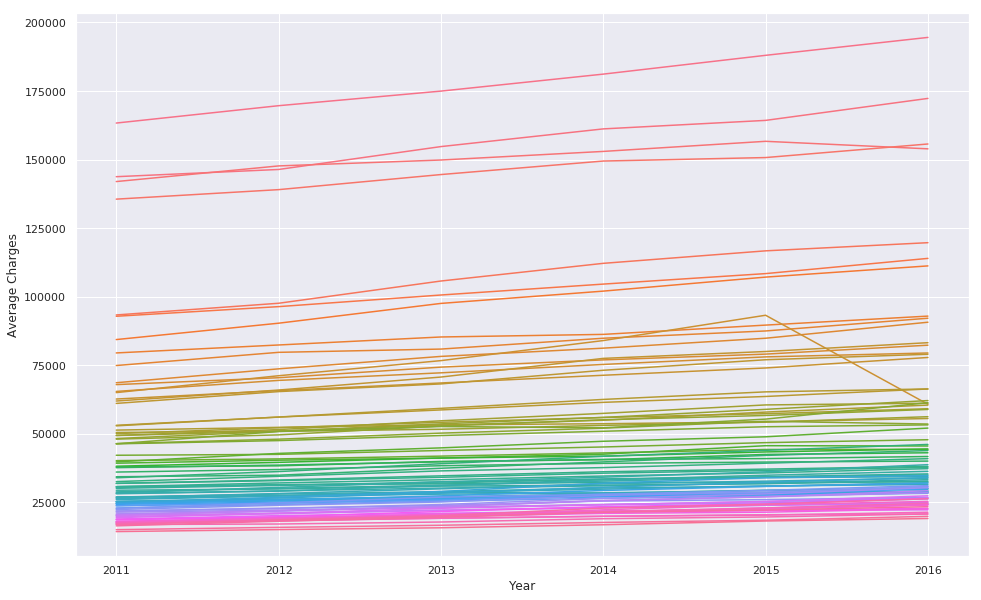

In [117]:
import seaborn as sns
import matplotlib.dates as mdates
sns.set(style="darkgrid")
# Plot the responses for different events and regions
sns.lineplot(x="Year", y="Average Charges",
             hue="DRG Definition",
             data=long_df, legend=False)


fig = plt.gcf()
fig.set_size_inches( 16, 10)

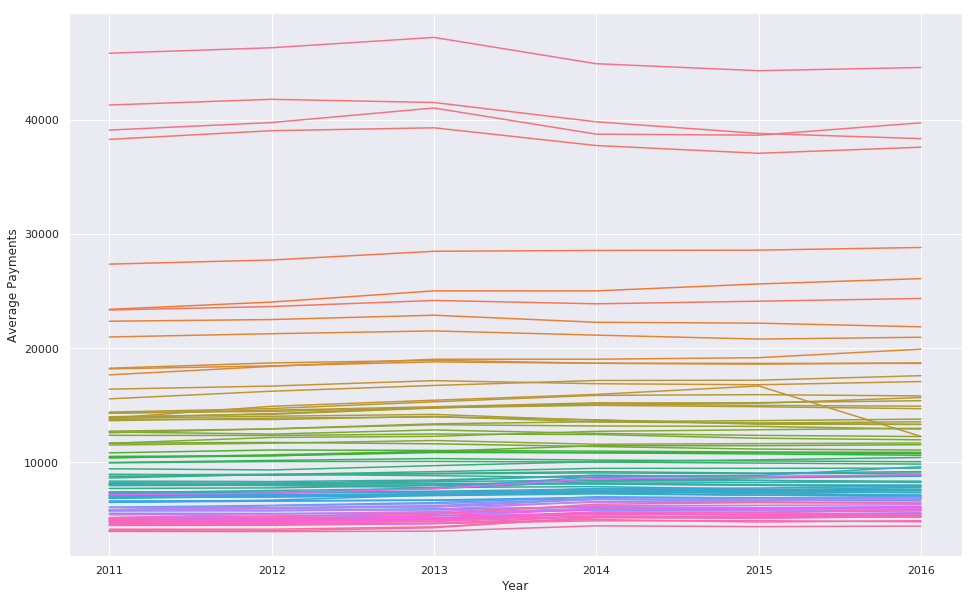

In [118]:
sns.lineplot(x="Year", y="Average Payments",
             hue="DRG Definition",
             data=long_df, legend=False)


fig = plt.gcf()
fig.set_size_inches( 16, 10)

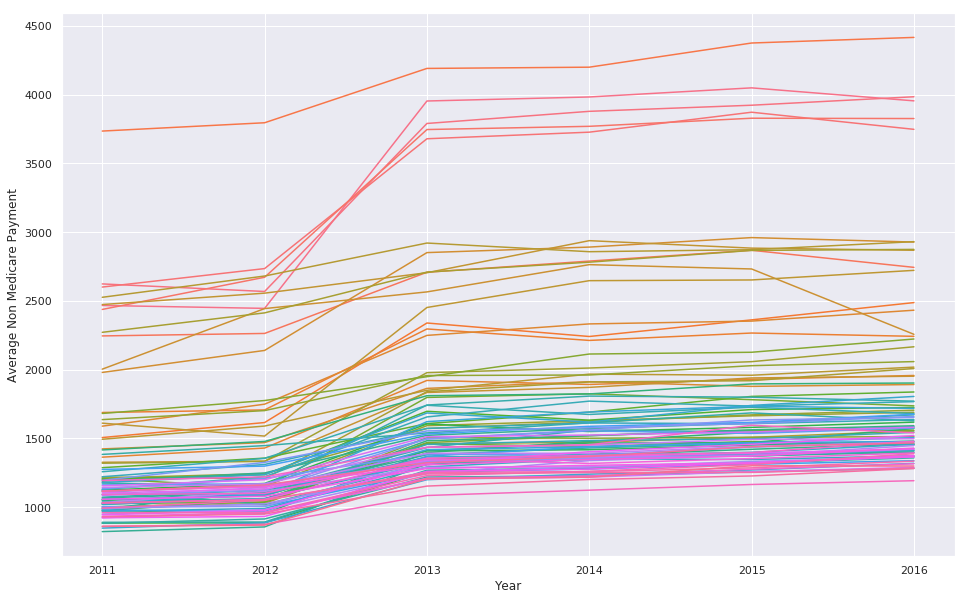

In [124]:
sns.lineplot(x="Year", y="Average Non Medicare Payment",
             hue="DRG Definition",
             data=long_df, legend=False)


fig = plt.gcf()
fig.set_size_inches( 16, 10)

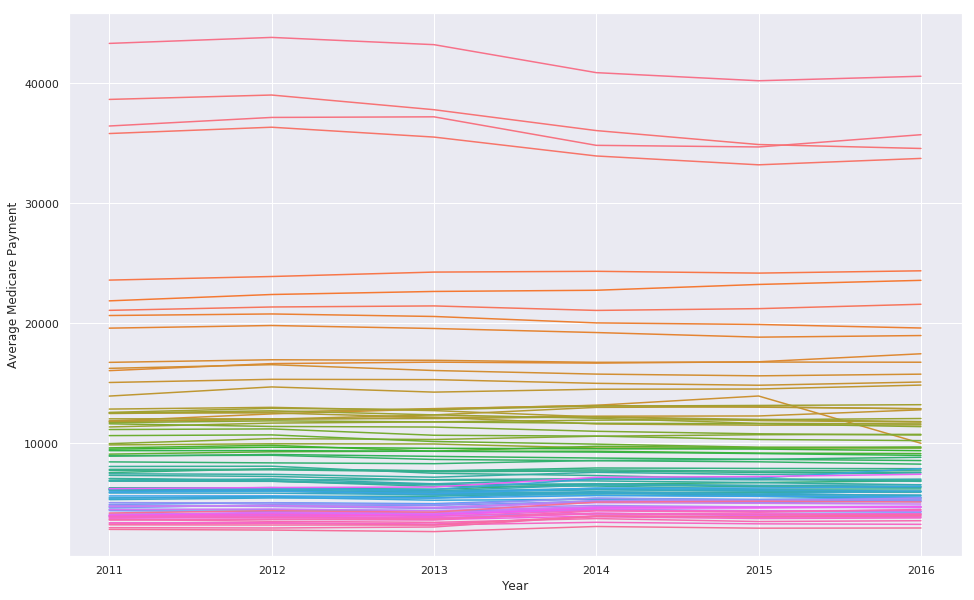

In [125]:
sns.lineplot(x="Year", y="Average Medicare Payment",
             hue="DRG Definition",
             data=long_df, legend=False)


fig = plt.gcf()
fig.set_size_inches( 16, 10)

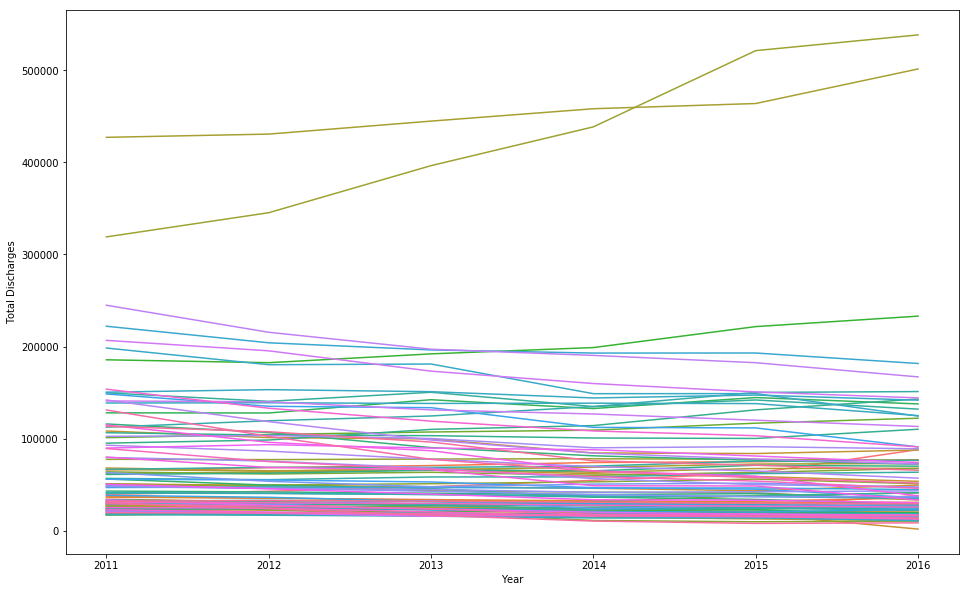

In [27]:
sns.lineplot(x="Year", y="Total Discharges",
             hue="DRG Definition",
             data=long_df, legend=False)


fig = plt.gcf()
fig.set_size_inches( 16, 10)

In [22]:
df_merged = df_merged.set_index('DRG Code')

In [26]:
df_num_cols = df_merged[['Total Discharges-2011', 'Average Charges-2011',
       'Average Payments-2011', 'Average Medicare Payment-2011',
       'Average Non Medicare Payment-2011', 'Total Discharges-2012',
       'Average Charges-2012', 'Average Payments-2012',
       'Average Medicare Payment-2012', 'Average Non Medicare Payment-2012',
       'Total Discharges-2013', 'Average Charges-2013',
       'Average Payments-2013', 'Average Medicare Payment-2013',
       'Average Non Medicare Payment-2013', 'Total Discharges-2014',
       'Average Charges-2014', 'Average Payments-2014',
       'Average Medicare Payment-2014', 'Average Non Medicare Payment-2014',
       'Total Discharges-2015', 'Average Charges-2015',
       'Average Payments-2015', 'Average Medicare Payment-2015',
       'Average Non Medicare Payment-2015', 'Total Discharges-2016',
       'Average Charges-2016', 'Average Payments-2016',
       'Average Medicare Payment-2016', 'Average Non Medicare Payment-2016']]
df_num_cols

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
DRG Code                                                                       
870                       22624         163325.924727           45800.304897   
207                       26412         143768.966115           39075.223118   
853                       39482         141995.086546           41267.558178   
329                       37250         135584.770120           38262.291436   
246                       27104          93363.315895           23336.481921   
460                       65997          92884.270225           27347.608649   
252                       34222          84391.353866           23389.605020   
469                       18714          79518.005077           22350.119429   
480                       17851          74927.733741           20972.504285   
253                       36434          68656.565159           17657.076549   
243                       29646          67968.686804           18181.944377   
330                       50766          65481.843615           18239.712879   
251                       28583          65054.383480           13877.647413   
208                       68080          62710.196842           16407.986017   
247                      108272          61985.034007           14292.068300   
286                       21820          61115.131897           15560.630614   
244                       27951          53134.335301           13990.301027   
473                       23834          52934.927834           14400.059872   
177                       66660          51383.269607           13857.547315   
64                        62093          50511.485981           13773.065869   
470                      427207          50105.260780           14324.484035   
314                       51079          49438.290902           13909.480608   
871                      319072          49418.600159           13650.959467   
481                       77525          48304.420884           12588.735556   
418                       18227          48091.444451           11518.103308   
377                       48398          46459.449729           12730.230898   
254                       26385          46399.256888           11668.784461   
280                       63934          46373.314262           12661.111944   
698                       22085          42212.746570           12369.462440   
682                      101029          40258.705372           11683.246751   
...                         ...                   ...                    ...   
66                        55849          23864.610468            5787.118068   
202                       32086          23776.084523            6082.141432   
282                       21596          23000.158455            5539.060937   
552                       63116          22808.392024            5841.400485   
101                       48854          22428.108261            5798.661031   
638                       48025          21892.232650            6069.980760   
69                        79590          21830.054705            5074.530142   
309                      102484          21461.879581            5849.762626   
812                       92851          20855.350648            5738.285210   
312                      141918          20541.310806            5156.213271   
392                      244854          20321.546816            5097.075817   
603                      140894          20272.376255            5887.524316   
690                      206695          19865.560768            5409.828549   
563                       20278          19464.267876            5171.738041   
379                       33393          18974.565897            5030.734196   
885                       89733          18761.074766            7180.196683   
948                       50411          18739.868620            4946.972347   
192       

In [28]:
norm_data = df_num_cols.apply(np.log)
norm_data

Total Discharges-2011  Average Charges-2011  Average Payments-2011  \
DRG Code                                                                       
870                   10.026767             12.003503              10.732046   
207                   10.181574             11.875963              10.573244   
853                   10.583600             11.863548              10.627832   
329                   10.525407             11.817352              10.552220   
246                   10.207437             11.444254              10.057773   
460                   11.097365             11.439110              10.216384   
252                   10.440624             11.343220              10.060047   
469                    9.837027             11.283739              10.014587   
480                    9.789815             11.224279               9.950968   
253                   10.503258             11.136872               9.778892   
243                   10.297082             11.126802               9.808184   
330                   10.834982             11.089528               9.811357   
251                   10.260567             11.082979               9.538035   
208                   11.128439             11.046279               9.705523   
247                   11.592402             11.034648               9.567460   
286                    9.990582             11.020515               9.652499   
244                   10.238208             10.880579               9.546120   
473                   10.078868             10.876819               9.574988   
177                   11.107360             10.847068               9.536585   
64                    11.036389             10.829956               9.530470   
470                   12.965024             10.821881               9.569726   
314                   10.841129             10.808481               9.540326   
871                   12.673172             10.808082               9.521565   
481                   11.258356             10.785278               9.440558   
418                    9.810659             10.780860               9.351675   
377                   10.787214             10.746335               9.451735   
254                   10.180551             10.745039               9.364673   
280                   11.065607             10.744479               9.446291   
698                   10.002654             10.650478               9.422986   
682                   11.523163             10.603082               9.365911   
...                         ...                   ...                    ...   
66                    10.930407             10.080152               8.663390   
202                   10.376175             10.076436               8.713112   
282                    9.980263             10.043256               8.619580   
552                   11.052730             10.034884               8.672726   
101                   10.796592             10.018070               8.665382   
638                   10.779477              9.993887               8.711111   
69                    11.284644              9.991043               8.531989   
309                   11.537462              9.974034               8.674156   
812                   11.438751              9.945366               8.654916   
312                   11.863005              9.930193               8.547958   
392                   12.408417              9.919437               8.536422   
603                   11.855763              9.917014               8.680591   
690                   12.239000              9.896743               8.595973   
563                    9.917292              9.876336               8.550964   
379                   10.416102              9.850855               8.523321   
885                   11.404594              9.839540               8.879082   
948                   10.827965              9.838409               8.506531   
192       

In [31]:
#KMeans 

kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(norm_data)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(norm_data)
pca_pairs = pca.transform(norm_data)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos],
     drg=np.array(df_merged[clusterIDs==0]['DRG Definition'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos],
     drg=np.array(df_merged[clusterIDs==1]['DRG Definition'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos],
     drg=np.array(df_merged[clusterIDs==2]['DRG Definition'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos],
     drg=np.array(df_merged[clusterIDs==3]['DRG Definition'])))   
                                                              

TOOLTIPS = [("DRG", "@drg") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=4", toolbar_location="below", tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(norm_data, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)

Silhouette Score:  0.36089556585628446
PCA Explained Variance Ratio:  [0.60175917 0.36477219]


In [35]:
# Finding the best k in range 2 -9 
sil_scores = {}

for n in range(2,9):
    kmeansModel = KMeans(init='random', n_clusters=n, n_init=10)
    kmeansModel.fit_predict(norm_data)
    clusterIDs = kmeansModel.labels_
    score = metrics.silhouette_score(norm_data, clusterIDs, metric='euclidean')
    sil_scores[n]=(score)

    
print("Silhouette Scores")
pp.pprint(sil_scores)

Silhouette Scores
{2: 0.3993399850470668,
 3: 0.39179593361493154,
 4: 0.35412284298526014,
 5: 0.3121593119075311,
 6: 0.3316948537968743,
 7: 0.3379937334784765,
 8: 0.34100716757129235}


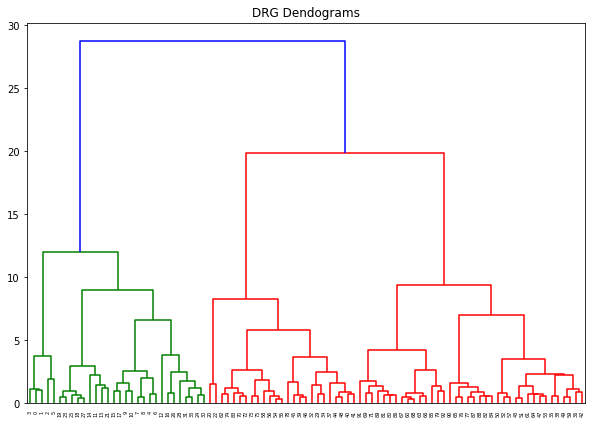

In [36]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("DRG Dendograms")  
dend = shc.dendrogram(shc.linkage(norm_data, method='ward'))  

In [98]:
import numpy as np

from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid
from bokeh.models.glyphs import MultiLine
from bokeh.io import curdoc, show
from bokeh.models import HoverTool
from bokeh.palettes import magma
from bokeh.palettes import Plasma256 as plasma
from bokeh.palettes import Category20_20 as cat20



yrs = [ 2011, 2012, 2013, 2014, 2015, 2016]

x = [yrs] * len(df_merged)

y = []

label = []

for index, row in df_merged.iterrows():
    
        fin_data = [ row['Average Charges-2011'],
                     row['Average Charges-2012'],
                     row['Average Charges-2013'],
                     row['Average Charges-2014'],
                     row['Average Charges-2015'],
                     row['Average Charges-2016']]
    
        y.append(fin_data)

        label.append(row['DRG Definition'])




crs = np.random.choice(cat20, len(df_merged))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        drg=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=4, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('DRG', '@drg')
]))

show(p)


In [99]:
y = []

label = []

for index, row in df_merged.iterrows():
    
        fin_data = [ row['Average Non Medicare Payment-2011'],
                     row['Average Non Medicare Payment-2012'],
                     row['Average Non Medicare Payment-2013'],
                     row['Average Non Medicare Payment-2014'],
                     row['Average Non Medicare Payment-2015'],
                     row['Average Non Medicare Payment-2016']]
    
        y.append(fin_data)

        label.append(row['DRG Definition'])




crs = np.random.choice(cat20, len(df_merged))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        drg=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=4, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('DRG', '@drg')
]))

show(p)


In [86]:
from bokeh.palettes import Category20c_20 as cat20
cat20

['#3182bd',
 '#6baed6',
 '#9ecae1',
 '#c6dbef',
 '#e6550d',
 '#fd8d3c',
 '#fdae6b',
 '#fdd0a2',
 '#31a354',
 '#74c476',
 '#a1d99b',
 '#c7e9c0',
 '#756bb1',
 '#9e9ac8',
 '#bcbddc',
 '#dadaeb',
 '#636363',
 '#969696',
 '#bdbdbd',
 '#d9d9d9']

In [100]:
y = []

label = []

for index, row in df_merged.iterrows():
    
        fin_data = [ row['Total Discharges-2011'],
                     row['Total Discharges-2012'],
                     row['Total Discharges-2013'],
                     row['Total Discharges-2014'],
                     row['Total Discharges-2015'],
                     row['Total Discharges-2016']]
    
        y.append(fin_data)

        label.append(row['DRG Definition'])




crs = np.random.choice(cat20, len(df_merged))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        drg=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=4, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('DRG', '@drg')
]))

show(p)


In [54]:
# get provider ids
pvdrs2011 = df2011['Provider Id'].unique()
pvdrs2012 = df2012['Provider Id'].unique()
pvdrs2013 = df2013['Provider Id'].unique()
pvdrs2014 = df2014['Provider Id'].unique()
pvdrs2015 = df2015['Provider Id'].unique()
pvdrs2016 = df2016['Provider Id'].unique()

#get intersection of provider ids
common_providers = reduce(np.intersect1d, (pvdrs2011, pvdrs2012, pvdrs2013, pvdrs2014, pvdrs2015, pvdrs2016))


#trim dataframes down
d2011 = trimToIntersect(df2011, 'Provider Id', common_providers)
d2012 = trimToIntersect(df2012, 'Provider Id', common_providers)
d2013 = trimToIntersect(df2013, 'Provider Id', common_providers)
d2014 = trimToIntersect(df2014, 'Provider Id', common_providers)
d2015 = trimToIntersect(df2015, 'Provider Id', common_providers)
d2016 = trimToIntersect(df2016, 'Provider Id', common_providers)

In [55]:
def groupByProvider(df_orig):
    #recover original values
    
    df = df_orig.copy()
    
    df['Total Charges'] = df['Total Discharges'] * df['Average Covered Charges']
    df['Total Payments'] = df['Total Discharges'] * df['Average Total Payments']
    df['Total Medicare Payments'] = df['Total Discharges'] * df['Average Medicare Payments']

    #group by , take sums
    newdf = df.groupby(['Provider Id']).agg({ 'Total Discharges':'sum',
                                              'Total Charges': 'sum',
                                              'Total Payments':'sum',
                                              'Total Medicare Payments': 'sum' })
  
    #calcuate new averages
    newdf['Average Charges'] = newdf['Total Charges']/newdf['Total Discharges']
    newdf['Average Payments'] = newdf['Total Payments']/newdf['Total Discharges']
    newdf['Average Medicare Payment'] = newdf['Total Medicare Payments']/newdf['Total Discharges']
    newdf['Average Non Medicare Payment'] = newdf['Average Payments'] - newdf['Average Medicare Payment']
    
    newdf.drop(columns=['Total Charges',
                     'Total Payments',
                     'Total Medicare Payments'], inplace=True)
    newdf = newdf.sort_values(by='Average Charges', ascending=False)
    

    return newdf



#group values by provider, but provider info is lost, will need to remerge
grpHP2011 = groupByProvider(d2011)
grpHP2012 = groupByProvider(d2012)
grpHP2013 = groupByProvider(d2013)
grpHP2014 = groupByProvider(d2014)
grpHP2015 = groupByProvider(d2015)
grpHP2016 = groupByProvider(d2016)

In [56]:
#add year for merging 
def addYearToCols(df, year):
    df = df.rename(columns={"Total Discharges": "Total Discharges-" + str(year),
                            "Average Charges": "Average Charges-" + str(year),
                            "Average Payments" : "Average Payments-" + str(year),
                            "Average Medicare Payment": "Average Medicare Payment-" + str(year),
                            "Average Non Medicare Payment": "Average Non Medicare Payment-" + str(year)})
    return df

grpHP2011 = addYearToCols(grpHP2011, 2011)
grpHP2012 = addYearToCols(grpHP2012, 2012)
grpHP2013 = addYearToCols(grpHP2013, 2013)
grpHP2014 = addYearToCols(grpHP2014, 2014)
grpHP2015 = addYearToCols(grpHP2015, 2015)
grpHP2016 = addYearToCols(grpHP2016, 2016)

In [57]:
#merge into one providers data set
dfs = [grpHP2011, grpHP2012, grpHP2013, grpHP2014, grpHP2015, grpHP2016 ]
providers_merged = reduce(lambda  left,right: pd.merge(left,right, left_index=True, right_index=True), dfs )
providers_merged.head()

Total Discharges-2011  Average Charges-2011  \
Provider Id                                                
310025                        1865         139928.855758   
50464                         2114         137026.475876   
50441                         3821         129410.735676   
50367                         1767         128504.076967   
50289                         1739         126404.843590   

             Average Payments-2011  Average Medicare Payment-2011  \
Provider Id                                                         
310025                 9263.087936                    8146.161930   
50464                 13729.954116                   12472.589404   
50441                 23122.702433                   21902.208323   
50367                 14971.096208                   13842.359366   
50289                 16990.764807                   15849.680851   

             Average Non Medicare Payment-2011  Total Discharges-2012  \
Provider Id                                                             
310025                             1116.926006                   1543   
50464                              1257.364712                   2671   
50441                              1220.494110                   3907   
50367                              1128.736842                   2065   
50289                              1141.083956                   1713   

             Average Charges-2012  Average Payments-2012  \
Provider Id                                                
310025              146934.896303            9142.480233   
50464               130894.862221           13807.092100   
50441               141310.930637           23220.147171   
50367               133579.189830           15183.386925   
50289               124265.229420           17115.810858   

             Average Medicare Payment-2012  Average Non Medicare Payment-2012  \
Provider Id                                                                     
310025                         8380.860013                         761.620220   
50464                         12744.516660                        1062.575440   
50441                         22019.616585                        1200.530586   
50367                         14054.031961                        1129.354963   
50289                         15473.059545                        1642.751312   

                           ...                  Total Discharges-2015  \
Provider Id                ...                                          
310025                     ...                                   1886   
50464                      ...                                   3518   
50441                      ...                                   8228   
50367                      ...                                   2296   
50289                      ...                                   1480   

             Average Charges-2015  Average Payments-2015  \
Provider Id                                                
310025              161943.987460            9813.446506   
50464               169778.671927           16456.094522   
50441               227553.435994           34887.983749   
50367               189042.177348           16237.647883   
50289               123180.959541           15827.233081   

             Average Medicare Payment-2015  Average Non Medicare Payment-2015  \
Provider Id                                                                     
310025                         8605.638494                        1207.808012   
50464                         15136.731387                        1319.363135   
50441                         30725.344322                        4162.639428   
50367                         14718.256882                        1519.391002   
50289                         14444.800885                        1382.432196   

             Total Discharges-2016  Average Charges-2016  \
Provider Id                                   

In [58]:
#Get Providers DataFrames
def getDFFromGroupObject(groupObj):
    uniq_rows = []
    cnames = []

    for i,group in groupObj:
        uniq_rows.append(np.array(group.iloc[0]))
        if len(cnames) == 0:
            cnames = group.iloc[0].index.values
            
    providers = pd.DataFrame(data=uniq_rows, columns=cnames)
    #providers = providers.set_index('Provider Id')
    return providers


#get provider info,ungrouped - since df are already have intersection, data from most recent should be sufficient
all_providers2016 = d2016[['Provider Id','Provider Name', 'Provider Street Address', 'Provider City','Provider State', 'Provider Zip Code']]

#grouped by id
group_providers2016 = all_providers2016.groupby('Provider Id')

p2016 = getDFFromGroupObject(group_providers2016)
p2016 = p2016.set_index('Provider Id')

In [61]:
## Write To CSV for GeoCoding
#for_trans = p2016[['Provider Id', 'Provider Street Address', 'Provider City','Provider State', 'Provider Zip Code']]
#for_trans = for_trans.set_index('Provider Id')
#for_trans.to_csv('provider_addrs.csv', header=False)

Provider Name  \
Provider Id                                                      
10001                         SOUTHEAST ALABAMA MEDICAL CENTER   
10005                            MARSHALL MEDICAL CENTER SOUTH   
10006                           ELIZA COFFEE MEMORIAL HOSPITAL   
10007                                 MIZELL MEMORIAL HOSPITAL   
10008                              CRENSHAW COMMUNITY HOSPITAL   
10011                                        ST VINCENT'S EAST   
10012                           DEKALB REGIONAL MEDICAL CENTER   
10016                            SHELBY BAPTIST MEDICAL CENTER   
10019                           HELEN KELLER MEMORIAL HOSPITAL   
10021                                      DALE MEDICAL CENTER   
10022                                  CHEROKEE MEDICAL CENTER   
10023                             BAPTIST MEDICAL CENTER SOUTH   
10024                            JACKSON HOSPITAL & CLINIC INC   
10029                              EAST ALABAMA MEDICAL CENTER   
10032                                         WEDOWEE HOSPITAL   
10033                           UNIVERSITY OF ALABAMA HOSPITAL   
10034                                   COMMUNITY HOSPITAL INC   
10035                          CULLMAN REGIONAL MEDICAL CENTER   
10036                              ANDALUSIA REGIONAL HOSPITAL   
10038                           STRINGFELLOW MEMORIAL HOSPITAL   
10039                                      HUNTSVILLE HOSPITAL   
10040                          GADSDEN REGIONAL MEDICAL CENTER   
10044                           MARION REGIONAL MEDICAL CENTER   
10045                                   FAYETTE MEDICAL CENTER   
10046                        RIVERVIEW REGIONAL MEDICAL CENTER   
10047                                 GEORGIANA MEDICAL CENTER   
10049                                MEDICAL CENTER ENTERPRISE   
10052                           LAKE MARTIN COMMUNITY HOSPITAL   
10055                                         FLOWERS HOSPITAL   
10056                                  ST VINCENT'S BIRMINGHAM   
...                                                        ...   
670005             MEMORIAL HERMANN SURGICAL HOSPITAL KINGWOOD   
670006                 THE HOSPITAL AT WESTLAKE MEDICAL CENTER   
670008                            HOUSTON PHYSICIANS' HOSPITAL   
670019                             UNIVERSITY GENERAL HOSPITAL   
670023                      METHODIST MANSFIELD MEDICAL CENTER   
670024                            NORTH CYPRESS MEDICAL CENTER   
670025                         THE HEART HOSPITAL BAYLOR PLANO   
670031                       ST LUKE'S PATIENTS MEDICAL CENTER   
670034                       SCOTT & WHITE HOSPITAL-ROUND ROCK   
670041                         SETON MEDICAL CENTER WILLIAMSON   
670043                      CEDAR PARK REGIONAL MEDICAL CENTER   
670044             TEXAS HEALTH PRESBYTERIAN HOSPITAL ROCKWALL   
670046                         USMD HOSPITAL  AT FORT WORTH LP   
670047                   SIERRA PROVIDENCE EAST MEDICAL CENTER   
670049                       NORTH CENTRAL SURGICAL CENTER LLP   
670053                           ST LUKE'S SUGAR LAND HOSPITAL   
670054             FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO   
670055                            METHODIST STONE OAK HOSPITAL   
670056                               SETON MEDICAL CENTER HAYS   
670059                              ST LUKES LAKESIDE HOSPITAL   
670060         BAYLOR SCOTT AND WHITE MEDICAL CENTER SUNNYVALE   
670061                           SOUTH TEXAS SURGICAL HOSPITAL   
670067       BAYLOR ORTHOPEDIC AND SPINE HOSPITAL AT ARLINGTON   
670068         TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND   
670069                             METHODIST MCKINNEY HOSPITAL   
670071        TEXAS HEALTH HEART & VASCULAR HOSPITAL ARLINGTON   
670073                          METHODIST HOSPITAL FOR SURGERY   
670075                       ST LUKE'S HOSPITAL AT THE VINTAGE   
670076       BAYLOR SCO

In [170]:
## Kmeans?

    
    

#providers_merged.hist()
norm_data = providers_merged.apply(np.log)
#providers_norm.hist()




#KMeans 

kmeansModel = KMeans(init='random', n_clusters=4, n_init=10)
kmeansModel.fit_predict(norm_data)
clusterIDs = kmeansModel.labels_


pca = PCA(n_components=2)
pca.fit(norm_data)
pca_pairs = pca.transform(norm_data)

[xpos,ypos] = [0,1]

clus1 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==0,xpos], 
     y=pca_pairs[clusterIDs==0,ypos]))#,
 #    drg=np.array(df_merged[clusterIDs==0]['DRG Definition'])))
clus2 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==1,xpos], 
     y=pca_pairs[clusterIDs==1,ypos]))#,
 #    drg=np.array(df_merged[clusterIDs==1]['DRG Definition'])))
clus3 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==2,xpos], 
     y=pca_pairs[clusterIDs==2,ypos]))#,
 #    drg=np.array(df_merged[clusterIDs==2]['DRG Definition'])))
clus4 = ColumnDataSource(dict(x=pca_pairs[clusterIDs==3,xpos], 
     y=pca_pairs[clusterIDs==3,ypos]))#,
 #    drg=np.array(df_merged[clusterIDs==3]['DRG Definition'])))   
                                                              

#TOOLTIPS = [("DRG", "@drg") ]
p = figure(plot_width=900, plot_height=600, title="Kmeans Clustering k=4", toolbar_location="below")#, tooltips=TOOLTIPS)
p.circle( x='x', y = 'y', source=clus1, size=9, color="gold")
p.circle( x='x', y = 'y', source=clus2, size=9, color="crimson")
p.circle( x='x', y = 'y', source=clus3, size=9, color="navy")
p.circle( x='x', y = 'y', source=clus4, size=9, color="aqua")
p.xaxis.axis_label = 'PCA 1'
p.yaxis.axis_label = 'PCA 2'

show(p)

print("Silhouette Score: ", metrics.silhouette_score(norm_data, clusterIDs, metric='euclidean'))
print("PCA Explained Variance Ratio: " , pca.explained_variance_ratio_)

Silhouette Score:  0.2864575219057981
PCA Explained Variance Ratio:  [0.71955923 0.16424342]


number of estimated clusters : 1


TypeError: unhashable type: 'numpy.ndarray'

<Figure size 432x288 with 0 Axes>

In [62]:

full_list = pd.merge(p2016, providers_merged, left_index=True, right_index=True)


In [63]:
full_list['id'] = full_list.index
providers_long = pd.wide_to_long(full_list, ['Total Discharges',
                                             'Average Charges',
                                             'Average Payments',
                                             'Average Medicare Payment',
                                             'Average Non Medicare Payment'], i='id' , j='Year', sep='-')
providers_long

Provider Name  \
id     Year                                                      
10001  2011                   SOUTHEAST ALABAMA MEDICAL CENTER   
10005  2011                      MARSHALL MEDICAL CENTER SOUTH   
10006  2011                     ELIZA COFFEE MEMORIAL HOSPITAL   
10007  2011                           MIZELL MEMORIAL HOSPITAL   
10008  2011                        CRENSHAW COMMUNITY HOSPITAL   
10011  2011                                  ST VINCENT'S EAST   
10012  2011                     DEKALB REGIONAL MEDICAL CENTER   
10016  2011                      SHELBY BAPTIST MEDICAL CENTER   
10019  2011                     HELEN KELLER MEMORIAL HOSPITAL   
10021  2011                                DALE MEDICAL CENTER   
10022  2011                            CHEROKEE MEDICAL CENTER   
10023  2011                       BAPTIST MEDICAL CENTER SOUTH   
10024  2011                      JACKSON HOSPITAL & CLINIC INC   
10029  2011                        EAST ALABAMA MEDICAL CENTER   
10032  2011                                   WEDOWEE HOSPITAL   
10033  2011                     UNIVERSITY OF ALABAMA HOSPITAL   
10034  2011                             COMMUNITY HOSPITAL INC   
10035  2011                    CULLMAN REGIONAL MEDICAL CENTER   
10036  2011                        ANDALUSIA REGIONAL HOSPITAL   
10038  2011                     STRINGFELLOW MEMORIAL HOSPITAL   
10039  2011                                HUNTSVILLE HOSPITAL   
10040  2011                    GADSDEN REGIONAL MEDICAL CENTER   
10044  2011                     MARION REGIONAL MEDICAL CENTER   
10045  2011                             FAYETTE MEDICAL CENTER   
10046  2011                  RIVERVIEW REGIONAL MEDICAL CENTER   
10047  2011                           GEORGIANA MEDICAL CENTER   
10049  2011                          MEDICAL CENTER ENTERPRISE   
10052  2011                     LAKE MARTIN COMMUNITY HOSPITAL   
10055  2011                                   FLOWERS HOSPITAL   
10056  2011                            ST VINCENT'S BIRMINGHAM   
...                                                        ...   
670005 2016        MEMORIAL HERMANN SURGICAL HOSPITAL KINGWOOD   
670006 2016            THE HOSPITAL AT WESTLAKE MEDICAL CENTER   
670008 2016                       HOUSTON PHYSICIANS' HOSPITAL   
670019 2016                        UNIVERSITY GENERAL HOSPITAL   
670023 2016                 METHODIST MANSFIELD MEDICAL CENTER   
670024 2016                       NORTH CYPRESS MEDICAL CENTER   
670025 2016                    THE HEART HOSPITAL BAYLOR PLANO   
670031 2016                  ST LUKE'S PATIENTS MEDICAL CENTER   
670034 2016                  SCOTT & WHITE HOSPITAL-ROUND ROCK   
670041 2016                    SETON MEDICAL CENTER WILLIAMSON   
670043 2016                 CEDAR PARK REGIONAL MEDICAL CENTER   
670044 2016        TEXAS HEALTH PRESBYTERIAN HOSPITAL ROCKWALL   
670046 2016                    USMD HOSPITAL  AT FORT WORTH LP   
670047 2016              SIERRA PROVIDENCE EAST MEDICAL CENTER   
670049 2016                  NORTH CENTRAL SURGICAL CENTER LLP   
670053 2016                      ST LUKE'S SUGAR LAND HOSPITAL   
670054 2016        FOUNDATION SURGICAL HOSPITAL OF SAN ANTONIO   
670055 2016                       METHODIST STONE OAK HOSPITAL   
670056 2016                          SETON MEDICAL CENTER HAYS   
670059 2016                         ST LUKES LAKESIDE HOSPITAL   
670060 2016    BAYLOR SCOTT AND WHITE MEDICAL CENTER SUNNYVALE   
670061 2016                      SOUTH TEXAS SURGICAL HOSPITAL   
670067 2016  BAYLOR ORTHOPEDIC AND SPINE HOSPITAL AT ARLINGTON   
670068 2016    TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND   
670069 2016                        METHODIST MCKINNEY HOSPITAL   
670071 2016   TEXAS HEALTH HEART & VASCULAR HOSPITAL ARLINGTON   
670073 2016                     METHODIST HOSPITAL FOR SURGERY   
670075 2016                  ST LUKE'S HOSPITAL AT THE VINTAGE   
670076 2016  BAYLOR SCO

In [66]:
import numpy as np

from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid
from bokeh.models.glyphs import MultiLine
from bokeh.io import curdoc, show
from bokeh.models import HoverTool
from bokeh.palettes import magma
from bokeh.palettes import Plasma256 as plasma
from bokeh.palettes import Category20_20 as cat20



yrs = [ 2011, 2012, 2013, 2014, 2015, 2016]

x = [yrs] * len(full_list)

y = []

label = []

for index, row in full_list.iterrows():
    
        fin_data = [ row['Average Charges-2011'],
                     row['Average Charges-2012'],
                     row['Average Charges-2013'],
                     row['Average Charges-2014'],
                     row['Average Charges-2015'],
                     row['Average Charges-2016']]
    
        y.append(fin_data)

        label.append(row['Provider Name'])




crs = np.random.choice(cat20, len(full_list))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        p=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=1, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Provider', '@p')
]))

show(p)


In [70]:

first_100 = full_list.head(100)



yrs = [ 2011, 2012, 2013, 2014, 2015, 2016]

x = [yrs] * len(first_100)

y = []

label = []

for index, row in first_100.iterrows():
    
        fin_data = [ row['Average Charges-2011'],
                     row['Average Charges-2012'],
                     row['Average Charges-2013'],
                     row['Average Charges-2014'],
                     row['Average Charges-2015'],
                     row['Average Charges-2016']]
    
        y.append(fin_data)

        label.append(row['Provider Name'])




crs = np.random.choice(cat20, len(first_100))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        p=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=1, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Provider', '@p')
]))

show(p)


In [71]:
x = [yrs] * len(full_list)

y = []

label = []

for index, row in full_list.iterrows():
    
        fin_data = [ row['Average Non Medicare Payment-2011'],
                     row['Average Non Medicare Payment-2012'],
                     row['Average Non Medicare Payment-2013'],
                     row['Average Non Medicare Payment-2014'],
                     row['Average Non Medicare Payment-2015'],
                     row['Average Non Medicare Payment-2016']]
    
        y.append(fin_data)

        label.append(row['Provider Name'])




crs = np.random.choice(cat20, len(full_list))

p = figure(plot_width=800, plot_height=500)

source = ColumnDataSource(dict(
        xs=x,
        ys=y,
        p=label,
        colors=crs
    )
)


p.multi_line(xs='xs', ys='ys', source=source, line_width=1, line_color='colors')
p.add_tools(HoverTool(show_arrow=False, line_policy='next', tooltips=[
    ('Provider', '@p')
]))

show(p)


In [72]:
providers_long.head()


Provider Name Provider City  \
id    Year                                                   
10001 2011  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN   
10005 2011     MARSHALL MEDICAL CENTER SOUTH          BOAZ   
10006 2011    ELIZA COFFEE MEMORIAL HOSPITAL      FLORENCE   
10007 2011          MIZELL MEMORIAL HOSPITAL           OPP   
10008 2011       CRENSHAW COMMUNITY HOSPITAL       LUVERNE   

               Provider Street Address Provider State  Provider Zip Code  \
id    Year                                                                 
10001 2011      1108 ROSS CLARK CIRCLE             AL              36301   
10005 2011  2505 U S HIGHWAY 431 NORTH             AL              35957   
10006 2011          205 MARENGO STREET             AL              35631   
10007 2011               702 N MAIN ST             AL              36467   
10008 2011         101 HOSPITAL CIRCLE             AL              36049   

            Total Discharges  Average Charges  Average Payments  \
id    Year                                                        
10001 2011            5405.0     32857.012395       8176.438668   
10005 2011            1419.0     16451.170543       6902.408739   
10006 2011            3901.0     33464.126890       7537.756216   
10007 2011             603.0     10857.281924       4405.252073   
10008 2011             161.0     15234.732918       5765.062112   

            Average Medicare Payment  Average Non Medicare Payment  
id    Year                                                          
10001 2011               7112.044958                   1064.393710  
10005 2011               5832.492600                   1069.916138  
10006 2011               6480.229428                   1057.526788  
10007 2011               3602.520730                    802.731343  
10008 2011               4810.397516                    954.664596

In [76]:
providers_long.loc[(10001)]

Provider Name Provider City Provider Street Address  \
Year                                                                           
2011  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   
2012  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   
2013  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   
2014  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   
2015  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   
2016  SOUTHEAST ALABAMA MEDICAL CENTER        DOTHAN  1108 ROSS CLARK CIRCLE   

     Provider State  Provider Zip Code  Total Discharges  Average Charges  \
Year                                                                        
2011             AL              36301            5405.0     32857.012395   
2012             AL              36301            5369.0     34407.730862   
2013             AL              36301            5679.0     34788.675119   
2014             AL              36301            7325.0     39095.054607   
2015             AL              36301            7251.0     38255.160503   
2016             AL              36301            7448.0     42533.408046   

      Average Payments  Average Medicare Payment  Average Non Medicare Payment  
Year                                                                            
2011       8176.438668               7112.044958                   1064.393710  
2012       7755.769045               6656.064258                   1099.704787  
2013       8361.478077               7247.604508                   1113.873569  
2014       9236.268805               8036.733515                   1199.535290  
2015       8569.073038               7437.702630                   1131.370408  
2016       8898.150373               7762.662642                   1135.487731

In [77]:
providers_long.describe()

Provider Zip Code  Total Discharges  Average Charges  Average Payments  \
count       18426.000000      18426.000000     18426.000000      18426.000000   
mean        51470.043634       2261.887387     38286.222836      10298.465255   
std         27798.655320       2483.933979     24082.368003       4024.308494   
min          1040.000000         11.000000      3189.677420       3291.318681   
25%         29925.000000        510.000000     21757.235711       7783.174817   
50%         48201.000000       1480.000000     32344.518109       9341.145578   
75%         75904.000000       3154.750000     48517.666735      11748.658086   
max         99801.000000      37886.000000    263892.143853     104906.369567   

       Average Medicare Payment  Average Non Medicare Payment  
count              18426.000000                  18426.000000  
mean                8780.146006                   1518.319249  
std                 3521.197453                    998.112071  
min                 2562.644068                    405.940000  
25%                 6589.098994                   1039.570411  
50%                 7963.243304                   1260.152053  
75%                10068.302470                   1637.115261  
max               102521.065228                  41268.184000

In [138]:
geolocs = pd.read_csv('GeocodeResults.csv', header=None)
geolocs = geolocs.set_index(0)
geolocs = geolocs.rename({1:'Address',
                          2:'Match',
                          3:'Match Type',
                          4:'Found Address',
                          5:'Interpolated Long/Lat',
                          6:'TIGER ID',
                          7:'Street Side'}, axis='columns')
geolocs.head()

Address     Match Match Type  \
0                                                                               
180013         250 PARK STREET, BOWLING GREEN, KY, 42101     Match      Exact   
180012  913 NORTH DIXIE AVENUE, ELIZABETHTOWN, KY, 42701  No_Match        NaN   
40062             7301 ROGERS AVE, FORT SMITH, AR, 72917  No_Match        NaN   
40069     1520 N DIVISION STREET, BLYTHEVILLE, AR, 72315     Match  Non_Exact   
180017        1301 NORTH RACE STREET, GLASGOW, KY, 42141     Match      Exact   

                                     Found Address Interpolated Long/Lat  \
0                                                                          
180013       250 PARK ST, BOWLING GREEN, KY, 42101   -86.43254,36.994846   
180012                                         NaN                   NaN   
40062                                          NaN                   NaN   
40069   1520 S DIVISION ST, BLYTHEVILLE, AR, 72315    -89.918686,35.9102   
180017          1301 N RACE ST, GLASGOW, KY, 42141   -85.90343,37.010834   

          TIGER ID Street Side  
0                               
180013  28005307.0           R  
180012         NaN         NaN  
40062          NaN         NaN  
40069   47216720.0           R  
180017  29522244.0           L

In [139]:
lonlat = geolocs['Interpolated Long/Lat'].str.split(',', expand=True)
lonlat = lonlat.rename({0:'Longitude', 1:'Latitude'}, axis=1)
lonlat = lonlat.set_index(geolocs.index)
lonloat = lonlat.astype(float)
lonlat.head()


Longitude   Latitude
0                            
180013   -86.43254  36.994846
180012         NaN        NaN
40062          NaN        NaN
40069   -89.918686    35.9102
180017   -85.90343  37.010834

In [140]:
geodata = pd.concat([geolocs, lonlat], axis=1, join='inner')
geodata

Address     Match  \
0                                                                     
180013          250 PARK STREET, BOWLING GREEN, KY, 42101     Match   
180012   913 NORTH DIXIE AVENUE, ELIZABETHTOWN, KY, 42701  No_Match   
40062              7301 ROGERS AVE, FORT SMITH, AR, 72917  No_Match   
40069      1520 N DIVISION STREET, BLYTHEVILLE, AR, 72315     Match   
180017         1301 NORTH RACE STREET, GLASGOW, KY, 42141     Match   
110146     2000 DAN PROCTOR DRIVE, SAINT MARYS, GA, 31558  No_Match   
180016         727 HOSPITAL DRIVE, SHELBYVILLE, KY, 40065     Match   
40067             101 HOSPITAL DRIVE, MAGNOLIA, AR, 71754  No_Match   
110143                3950 AUSTELL RD, AUSTELL, GA, 30106     Match   
180019       989 MEDICAL PARK DRIVE, MAYSVILLE, KY, 41056  No_Match   
330208             976 NORTH BROADWAY, YONKERS, NY, 10701     Match   
180018            222 MEDICAL CIRCLE, MOREHEAD, KY, 40351     Match   
270057              915 HIGHLAND BLVD, BOZEMAN, MT, 59715     Match   
330202           451 CLARKSON AVENUE, BROOKLYN, NY, 11203     Match   
500008             1959 NE PACIFIC ST, SEATTLE, WA, 98195     Match   
330203             736 IRVING AVENUE, SYRACUSE, NY, 13210     Match   
500007            1211  24TH STREET, ANACORTES, WA, 98221     Match   
330204   FIRST AVENUE AT 27TH STREET, NEW YORK, NY, 10016  No_Match   
330205          15 - 19  MAPLE AVENUE, WARWICK, NY, 10990  No_Match   
500005  1100 NINTH AVENUE (PO BOX 900), SEATTLE, WA, 9...  No_Match   
180011          1001 SAINT JOSEPH LANE, LONDON, KY, 40741  No_Match   
270051           310 SUNNYVIEW LANE, KALISPELL, MT, 59901     Match   
180010       ONE SAINT JOSEPH DRIVE, LEXINGTON, KY, 40504  No_Match   
330201        585 SCHENECTADY AVENUE, BROOKLYN, NY, 11203     Match   
490110      3700 SOUTH MAIN STREET, BLACKSBURG, VA, 24060  No_Match   
500011         16251 SYLVESTER ROAD SW, BURIEN, WA, 98166     Match   
490112    1401 JOHNSTON WILLIS DRIVE, RICHMOND, VA, 23235     Match   
170200           14800 WEST ST TERESA, WICHITA, KS, 67235     Match   
340008            500 LAUCHWOOD DR, LAURINBURG, NC, 28352     Match   
490111         600 WEST RIDGE ROAD, WYTHEVILLE, VA, 24382     Match   
...                                                   ...       ...   
120001             1301 PUNCHBOWL ST, HONOLULU, HI, 96813     Match   
140058          1600 W WALNUT ST, JACKSONVILLE, IL, 62650  No_Match   
120002            221 MAHALANI STREET, WAILUKU, HI, 96793     Match   
140059      400 MAPLE SUMMIT ROAD, JERSEYVILLE, IL, 62052     Match   
450713         901 WEST BEN WHITE BLVD, AUSTIN, TX, 78704     Match   
50534              47-111 MONROE STREET, INDIO, CA, 92201  No_Match   
120007      347 NORTH KUAKINI STREET, HONOLULU, HI, 96817     Match   
50537                 2000 SUTTER PLACE, DAVIS, CA, 95616     Match   
420080  25 HOSPITAL CENTER BLVD, HILTON HEAD ISL, SC, ...  No_Match   
420085  809 82ND PARKWAY BOX 7500, MYRTLE BEACH, SC, 2...  No_Match   
290053     8280 W WARM SPRINGS ROAD, LAS VEGAS, NV, 89113     Match   
290054            6900 N DURANGO DR, LAS VEGAS, NV, 89149  No_Match   
420083    1700 SKYLYN DR BOX 3217, SPARTANBURG, SC, 29307     Match   
420082           302 UNIVERSITY PARKWAY, AIKEN, SC, 29801     Match   
420089        2000 HOSPITAL DR, MOUNT PLEASANT, SC, 29464  No_Match   
450709         18300 ST JOHN DRIVE, NASSAU BAY, TX, 77058     Match   
420087              316 CALHOUN ST, CHARLESTON, SC, 29401     Match   
420086              TAYLOR AT MARION, COLUMBIA, SC, 29220  No_Match   
140063               520 S MAPLE AVE, OAK PARK, IL, 60304     Match   
140064          3333 NORTH SEMINARY, GALESBURG, IL, 61401     Match   
140065     5101 S WILLOW SPRINGS RD, LA GRANGE, IL, 60525  No_Match   
420079       9330 MEDICAL PLAZA DR, CHARLESTON, SC, 29406     Match   
140067             530 NE GLEN OAK AVE, PEORIA, IL, 61637  No_Match   
140068              45 W 111TH STREET, CHICAGO, IL, 60628       Tie   
505

In [141]:
geodata.drop(columns=['Interpolated Long/Lat', 'TIGER ID', 'Street Side'], inplace=True)
geodata['Longitude'] = geodata['Longitude'].astype(float)
geodata['Latitude'] = geodata['Latitude'].astype(float)
geodata.dtypes

Address           object
Match             object
Match Type        object
Found Address     object
Longitude        float64
Latitude         float64
dtype: object

In [142]:
complete_geo = geodata.dropna()

In [143]:
complete_geo.dtypes

Address           object
Match             object
Match Type        object
Found Address     object
Longitude        float64
Latitude         float64
dtype: object

In [129]:
for r in complete_geo.itertuples():
    print(r)

Pandas(Index=180013, Address='250 PARK STREET, BOWLING GREEN, KY, 42101', Match='Match', _3='Exact', _4='250 PARK ST, BOWLING GREEN, KY, 42101', Longitude='-86.43254', Latitude='36.994846')
Pandas(Index=40069, Address='1520 N DIVISION STREET, BLYTHEVILLE, AR, 72315', Match='Match', _3='Non_Exact', _4='1520 S DIVISION ST, BLYTHEVILLE, AR, 72315', Longitude='-89.918686', Latitude='35.9102')
Pandas(Index=180017, Address='1301 NORTH RACE STREET, GLASGOW, KY, 42141', Match='Match', _3='Exact', _4='1301 N RACE ST, GLASGOW, KY, 42141', Longitude='-85.90343', Latitude='37.010834')
Pandas(Index=180016, Address='727 HOSPITAL DRIVE, SHELBYVILLE, KY, 40065', Match='Match', _3='Exact', _4='727 HOSPITAL DR, SHELBYVILLE, KY, 40065', Longitude='-85.23607', Latitude='38.210457')
Pandas(Index=110143, Address='3950 AUSTELL RD, AUSTELL, GA, 30106', Match='Match', _3='Exact', _4='3950 AUSTELL RD, AUSTELL, GA, 30106', Longitude='-84.6005', Latitude='33.858223')
Pandas(Index=330208, Address='976 NORTH BROADW

Pandas(Index=10138, Address='751 DERBY DRIVE, YORK, AL, 36925', Match='Match', _3='Exact', _4='751 DERBY DR, YORK, AL, 36925', Longitude='-88.296295', Latitude='32.492416')
Pandas(Index=100070, Address='540 THE RIALTO, VENICE, FL, 34285', Match='Match', _3='Non_Exact', _4='540 THE RIALTO, VENICE, FL, 34285', Longitude='-82.444405', Latitude='27.090944')
Pandas(Index=160117, Address='350 NORTH GRANDVIEW AVENUE, DUBUQUE, IA, 52001', Match='Match', _3='Exact', _4='350 N GRANDVIEW AVE, DUBUQUE, IA, 52001', Longitude='-90.687744', Latitude='42.4954')
Pandas(Index=100072, Address='1055 SAXON BLVD, ORANGE CITY, FL, 32763', Match='Match', _3='Exact', _4='1055 SAXON BLVD, ORANGE CITY, FL, 32763', Longitude='-81.28353', Latitude='28.911299')
Pandas(Index=100077, Address='2500 HARBOR BLVD, PORT CHARLOTTE, FL, 33952', Match='Match', _3='Exact', _4='2500 HARBOR BLVD, PORT CHARLOTTE, FL, 33952', Longitude='-82.096756', Latitude='26.989653')
Pandas(Index=240132, Address='550 OSBORNE ROAD, FRIDLEY, MN

In [178]:
from folium.plugins import MarkerCluster
 
USA_COORDINATES = (37.0902, -95.7129)

 
# for speed purposes
#MAX_RECORDS = 1000
  
# create empty map zoomed in on San Francisco
m = folium.Map(location=USA_COORDINATES, zoom_start=3.5)

mc = MarkerCluster()
 
# add a marker for every record in the filtered data, use a clustered view
for r in complete_geo.itertuples():

    mc.add_child(folium.Marker(
        location=[ r.Latitude, r.Longitude],
#        popup=folium.Popup("Lets try quotes", parse_html=True),
        icon=folium.Icon(color='green')
    ))
        
        
m.add_child(mc)

display(m)


In [165]:
found = complete_geo.index

In [ ]:
geodata[]